**Analysis of cluster algorithms for Monte Carlo methods applied to the Ising model**
=================================================================================
This report explores the efficiency and performance of cluster algorithms for Markov Chain Monte Carlo (MCMC) methods specifically for the case of the Ising model. In particular, the Wolff algorithm is implemented, analysed and compared to the Metropolis-Hastings (MH) algorithm. The performance of these algorithms is studied near criticality, exploring autocorrelation times and the phenomenon of critical slowing down. **ETC**

## 1.  Introduction

Monte Carlo methods have existed in some form since the 18th Century (Buffon's Needle Problem) but they were first applied to physical systems in the late 1940s within the Manhattan Project **[REFERENCE Ulam, Von Neumann]** to neutron diffusion in nuclear fission. They were extensively developed throughout the second half of the 20th century by the likes of Metropolis **[REFERENCE 1953]** and Hastings **[REFERENCE 1970]** with the Metropolis-Hastings Algorithm (originally referred to as the Metropolis Algorithm before Hastings generalised from symmetric to general proposcal distributions) one of the first techniques used to approximate distributions and integrals. Monte Carlo methods are applied frequently in statistical mechanics, specifically for thermodynamic systems like the Ising model which will be used in this report. 
    
The Metropolis-Hastings (MH) algorithm and the Glauber algorithm **[REFERENCE GLAUBER]** use local updates when proposing transitions in order to have efficient acceptance rates. However, in models with second order phase transitions, like the ferromagnetic case of the Ising model, these methods run into the problem of large autocorrelation times and the phenomenon of critical slowing down near criticality. This can be explained by considering the scale invariance of the system at the critical temperature (see section **REFERENCE**).

Cluster algorithms were formulated as a solution to this problem; they use non local updates to explore the state space more quickly and take advantage of updating multiple sites (flipping multiple spins in the context of the Ising model) to decorrelate system measurements and produce independent states faster (see section **REFERENCE**)

This report aims to build on the body of work surrounding these algorithms in the specific case of the 2D Ising model, chosen due to the ability to compare numerical with analytical and exact results. Specifically, the Wolff algorithm **[REFERENCE]** will be described and analysed considering the *detailed balance condition* followed by computational study of its performance and efficieny compared to the MH algorithm by studying autocorrleation times near criticality and comparing the algorithms' dynamic exponents. The code is writted that allows for changes in the size, $N$, of the lattice.

## 2. Theoretical Background

### 2.1. The 2D Ising model

The 2D ferromagnetic Ising model consists of a $L \times L$ lattice of size $N = L^{2}$ where on each vertex, $i$, of the lattice, there is a one-component type spin, $s_i$ that can take the values $s_i = \pm 1$ giving the configuration $s \equiv \{s_i\}$. In the ferromagnetic case with no external field $J > 0$ and the Hamiltonian $\mathcal{H}$ of the system is given by:

$$
\mathcal{H} = - J \sum_{i,\delta}s_is_{i+\delta}\tag{1}$$

Where the sum runs over all sites on the lattice, $i$, and the $\delta$ sum runs over the nearest neighbours. The configuration probability, $p(s)$, and canonical partition function, $Z$, at inverse temperature $\beta=\frac{1}{k_{B}T}$ are given by:

$$p(s) = \frac{1}{Z} e^{-\beta H(\{s_i\})}, \qquad Z = \sum_{\{s_i\}} e^{-\beta H(\{s_i\})}.\tag{2,3}$$

With $s \equiv \{s_i\} \in \{-1,1\}^N.$ The sum runs over all spin configurations $\{s_i\}$. One of the most important variables of the system is the overall relative magnetisation of the complete lattice and the corresponding expected total magnetisation

$$M = \frac{1}{N}\sum_i^N s_i, \qquad \mathbb{E}[M]=\sum_{s}M(s)p(s).\tag{4,5}$$

The expectation value of any observable can be computed in the same way. For the case of no external field, an analytic solution for the mean total magnetisation was discovered by Lars Onsager **[REFERENCE]** 

$$
\langle M \rangle = \begin{cases}0 & \text {if } T \geq T_c \\ 
\pm \left(1-\sinh \left(2 \beta J\right)^{-4}\right)^{\frac{1}{8}} & \text {if } T<T_c\end{cases}\tag{6}
$$
The critical temperature $T_c=\frac{2 J}{k_b \ln (1+\sqrt{2})}$ determines where the phase transition occurs. Since the mean magnetisation continuosly characterises the phase transition **(see figure X)** it is a suitable order parameter for the transition.

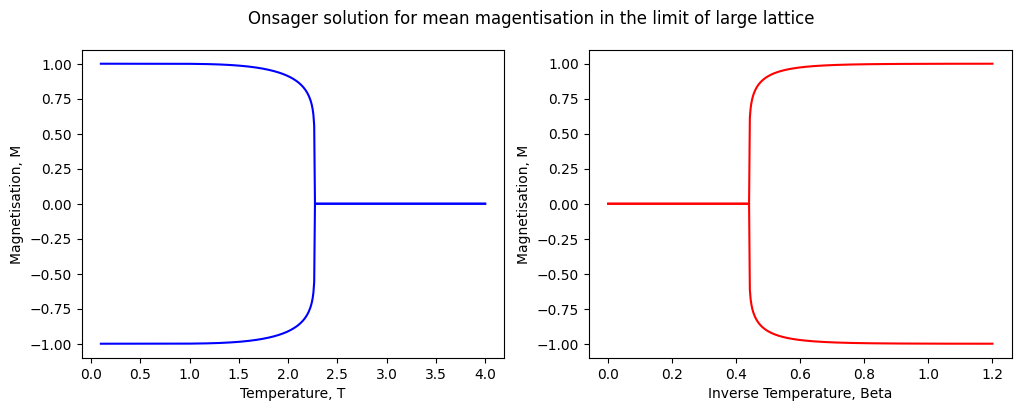

In [22]:
%run onsager #plots the analytic solution for mean magnetisation given above

Near criticality, that is: near $t = \frac{T}{T_c}-1 \ll 1$ (or $T \approx T_c$), expressions for observables such as the mean magnetisation, susceptibilty, $\chi$, and correlation length, $\xi$, obtained from a mean field theory approach can be expanded around $t = 0$ and the physical quantities can be expressed as critical exponents of $t$. These are universal values and characterize the singular properties of the physical quantities. The scale invariance of the system near criticality is clearly displayed as the quantities do not depend on specific parameters of the model or lattice. The critical exponents used in this report are $\nu$ and $\beta$ defined as

$$ \xi \propto |T-T_c|^{-\nu}, \qquad \langle M \rangle \propto \pm|T-T_c|^\beta\tag{7,8}.$$

Mean field theory results for the 2D Ising model predict $\nu = 1$ and $\beta = 1/8$ **[REFERENCE]**. It is important to note here the significance of the correlation length to both the mean field theory approch and the computational aspects of MCMC methods. The correlation length is the characteristic length scale at which mean properties of the system become independent from the individual components, that is, the length at which correlations decrease significantly. Above the critical temperature, this gives an indication of the maximum size of clusters of correlated spins. As $T$ approaches $T_c$, $\xi$ starts to diverge and clusters of all sizes start to appear, essentially, correlations and fluctuations on all scales become equally important and this has significant impacts on the computational aspects of this system (see section **[REFERENCE]**).

### 2.2. Algorithms

Monte Carlo Markov Chain processes are suitable for the Ising model. Since there can be such large variation in sample means (from $e^{-2N\beta J}/Z$ to $e^{2N\beta J}/Z$) and brute force calculations require sums over $2^N$ terms, methods that avoid calculating the partition function through ratios of probabilities are advantageous. MCMC methods evolve the Ising configuration and involve much less computational effort and only require the desired probability distribution up to a normalisation factor. 

Markov Chain algorithms (uniquely) defined by a transition probability matrix $P(x \to x')$ of a given state $x$ to any state $x'$ must satisfy two conditions in order to have unique stationary distribution $\pi(x)$ that asymptotically reaches the desired distribution $P(x)$:

1. *Detailed Balance*: a sufficient condition for the existence of a stationary distribution is the detailed balance condition, it requires that each transition is reversible, that is, the flow of probability between any two states $x$ and $x'$ is the same in both directions.
$$ \pi(x)P(x \to x') = \pi(x')P(x' \to x)\tag{9}$$

2. *Irreducible and aperiodic*: A transition matrix is irreducible if for every pair of states $x,x'$ in the state space the chance of a Markov chain connecting them is non zero. It is aperiodic if there is no set, single finite number of steps in a Markov chain separating the states. This ensures the stationary distribution is convergent, unique and independent of the initial distribution. This condition is also known as *ergodicity*.

The algorithms are outlined below and the two conditions are shown to be satisfied in each case

**Metropolis-Hastings Algorithm**

The Metropolis-Hastings algorithm splits the transition matrix into a proposal and acceptance probability $P(x \to x') = q(x \to x')A(x \to x')$ and so detailed balance is satisfied if:
$$ \frac{A(x \to x')}{A(x' \to x)} = \frac{\pi(x')q(x' \to x)}{\pi(x)q(x \to x')}$$
The choice of $A$ in the Metropolis-Hastings algorithm is:
$$ A(x \to x') = min\left(1,\frac{\pi(x')q(x' \to x)}{\pi(x)q(x \to x')}\right)$$
Which explicitly satisfies detailed balance; either $A(x \to x') = 1$ and $A(x' \to x) = \frac{\pi(x)q(x \to x')}{\pi(x')q(x' \to x)}$ or vice versa (with the primes switched) which shows that the acceptance probability is reversible.
The choice of the proposal transition matrix must be irreducible and reversible. The simplest choice, in the case of the Ising model, is to select any one site $i$ on the lattice with uniform likelihood and flip the spin. This is clearly reversible and it is irreducible and aperiodic because any other state in the state space can be reached by a succession of single spin flips.

The desired distribution is $\pi(s) = p(s) = e^{-\beta H(s)}/Z$ for $s = \{s_i\}$ and so $$A(s \to s') = min\left(1,e^{-\beta\Delta E}\right) = \begin{cases} 1 &\text{if }\Delta E \leq 0 \\ e^{-\beta\Delta E} &\text{if }\Delta E > 0 \end{cases}\tag{10}$$ where $$\Delta E = H(s') - H(s) = 2J s_i \sum_{\delta} s_{i+\delta}\tag{11}$$
with the sum over the 4 neighbours $\delta$ of $i$.

**Wolff Algorithm & Cluster Algorithms**

<!--- Cluster algorithms were introduced to reduce the phenomena of large autocorrelation times near criticality (critical slowing down) (see section **2.3**). These algortithms get around this problem by working on the basis of growing clusters from a particular seed site $i_{seed}$ and then flipping multiple spins in a non-local update, exploring the phase space more quickly. This means that even near criticality, the lattice should be decorrelated because large percolation clusters are flipped together compared to the MH case where this must happen spin by spin. Traditionally, the energy change for such a move would be very large implying a very small acceptance probability for the MH algorithm which needs small changes in energy for satisfactory acceptance rates, however most cluster algorithms are rejection free (subsequent states in the Markov chain are always different) and work by adding to the cluster with a probability $0<p_{add}<1$. -->

In the Wolff algorithm, the next state $s'$ in the chain is obtained by flipping all the spins in a randomly generated cluster $C$:
$$ s' = \begin{cases} -s_i & i \in C \\ s_i & i \notin C \end{cases} $$
$C$ is constructed iteratively from a random seed site. Neighbouring spins with the same spin value (aligned) are added to the cluster with probability $0<p_{add}<1$, with each site in the cluster visited only once. The cluster is finished when every site has been visited once.

Since there is a $(1 - p_{add})^4>0$ chance that the move is a single-flip one then the transition is irreducible (as in MH case above). The transition is also aperiodic since it is possible to return to a state in 2, 3 or more moves via single, double or multi-flip moves, that is, there is no set number of moves to return to a state.

Detailed balance can be satisfied by a specific choice of $p_{add}$:

Consider the set of possible clusters $C$, for each $C$, the only difference between the backwards and forwards transitions, $P(s \to s') \text{and } P(s' \to s)$ occurs at the boundrary of the cluster (since all spins are aligned inside by definition). Then comparing the ratios of these probabilities will lead to detailed balance. Let $m$ be the number of spins bordering $C$ in aligned states and $m$ be the number of spins bordering $C$ in anti-aligned states then:
$$
P(C \text{ selected for } s \to s') \propto (1-p_{add})^m, \quad P(C \text{ selected for } s' \to s) \propto (1-p_{add})^n\tag{12}
$$
Since in the reverse case, the cluster is flipped and $m$ and $n$ are exchanged. Putting equations (9) and (12) together along with equation (2) for the desired distribution, we arrive at the detailed baance requirement for $p_{add}$:
$$
\frac{P(s \to s')}{P(s' \to s)} = \frac{\pi(s')}{\pi(s)} = (1-p_{add})^{m-n} = e^{-\beta\Delta E}.
$$
Where, following from equation (11), $\Delta E = 2Jm - 2Jn$ and so detailed balance is satisfied for
$$ p_{add} = 1 - e^{-2\beta J}\tag{13}.$$

### 2.3. Autocorrelation and Critical Slowing Down

Consecutive Markov chain processes are always correlated since each state is generated from the precious one, as such each new state only provides a small increase in the information about the stationary distribution. This is important to consider when taking averages over states for the calculation of physical quantities since correlated states will introduce significant error. Temporal correlations (temporal in the context of the Markov chain) can be quantified by the autocorrelation function $\rho_Q(t)$ of measureable physical quantity (or observable) $Q$ evaluated at a time $t$.
$$
\rho_Q(t) = \operatorname{Corr}(Q_i,Q_{i+t}) = \frac{\bar{c}(t)}{\bar{c}(0)}
$$
Where $\bar{c}(t)$ and $\bar{c}(0)$ are the sample autocovaraince and sample variance respectively. They can be estimated by:
$$
\bar{c}(t) = \langle Q_i Q_{i+t} \rangle - \langle Q_i \rangle \langle Q_i \rangle
$$
It is clear from these definitions that the autocorrelation depends on the choice of observabe. For the purposes of this report the observable will be the absolute magnetisation per spin: chosen for its ease of implementation and efficient calculation. Other choices include the energy, magnetic susceptibility and heat capacity however due to time constraints these are not considered in the report.

In this specific case, the autocorrelation function can be shown to initially contain exponentially decaying modes that dominate for large enough time separations. This can be used to define the autocorrelation time $\tau_a$ such that $\rho_Q(t) \approx e^{-t/\tau_a}$. Other modes are indeed present but on the timescales concerned for autocorrelation times, this assumption will be shown to hold reasonanly well. Times can be estimated by taking the time value of the first entry in the autocorrelation series that drops below $1/e$.

Autocorrelation times are useful when considering behaviour near the critical temperature at the phase transition. They can be interpreted as the time (in algorithm moves) for states in the Markov chain to become statistically independent. This is pertinent becuase, as mentioned in section 2.1 **[REFERENCE]**, when $T \to T_c$ the lattice becomes highly correlated and the correlation length $\xi \propto |T-T_c|^{-\nu} \to \infty$. This means that at the critical temperature, cluster sizes exist on all scales and as such, all algorithms - but especially local, single flip algorithms like the Metropolis-Hastings algorithm - struggle to flip large clusters and generate independent states i.e. autocorrelation times also diverge. This is known as *critical slowing down* at a phase transition. This can be expressed quantitavely by the *dynamical exponent* $z$ which relates the autocorrelation time to the correlation length in the infinite size limit:
$$
\tau_a \propto |T-T_c|^{-\nu z} = \xi^z
$$
The dynamic exponent is not a universal quantity like the critical exponents of the model and so it depends on the algorithm used. Any algorithm with a value of $z > 0$ experiences critical slowing down but the closer the value is to 0, the better the algorithm performs near criticality. For for finite size lattices the cluster size cannot diverege and the maximum correlation length is limited to the width of the lattice $L$ - a good approximation of the scale law is:
$$
\tau_a \propto L^z
$$
This provides a quantitive way of comparing the algorithms. Section 3.5 of this report will aim to compare the performance of the two algorithms near criticality and investigate if non-local/cluster algorithms can reduce these effects significantly.

## 3. Implementation and Results

### 3.1. Initial Setup

The code below imports the required libraries and modules. `initial.py` defines some useful functions that are used throughout the report and the repository such as creating and plotting lattices, finding neighbouring spin sites, mangetisation, autocorrelation autocorrelation times. Note, periodic boundrary conditions have been used and so each site has the same number of neighbours.

Note also that in the analysis above and the implementation below, $J$ never appears separately from $\beta$ so it is safely set to 1 alongside the Boltzmann constant $k_B$ and natural units are assumed.

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pylab as plt
rng = np.random.default_rng()
import functions.initial as initial

In [2]:
"""
metropolis.py
Defines Metropolis-Hastings algorithm
"""
import functions.initial as initial

def compute_acceptance(i, j, lattice, width, betaJ):
    """Computes the acceptance probability from energy difference between the old and 
       new state if spin [i,j] would be flipped.
    """
    betaDeltaE=2*(betaJ*lattice[i,j]*initial.neighbouring_spins_sum(i, j, lattice, width))
    acceptance=np.exp(-1*betaDeltaE)
    return acceptance, betaDeltaE

def MH_flip(lattice, width, betaJ):
    """Proposes a new site to be flipped (proposal matrix) and accepts or rejects the flip based on MH acceptance matrix"""
    i, j = np.random.randint(0,width,2)

    acceptance, betaDeltaE=compute_acceptance(i, j, lattice, len(lattice), betaJ)

    #comparing probabilities
    if betaDeltaE <= 0:
        lattice[i,j]= -1*lattice[i,j]
    else:
        if acceptance > np.random.rand():
            lattice[i,j]*= -1

def n_MH_moves(lattice, width, betaJ, n):
    for i in range(n):
        MH_flip(lattice, width, betaJ)

def evolve_and_plot_MH(lattice, width, betaJ, plot_times):
    """Evolves the lattice using MH algorithm and plots the lattice at different 'time steps'."""
    fig, ax = plt.subplots(1, len(plot_times), figsize=(16,6))
    
    for t in range(plot_times[-1]+1):
        MH_flip(lattice, width, betaJ)
        if t in plot_times:
            initial.plot_lattice(lattice, ax[plot_times.index(t)], "t = {}".format(t))
            ax[plot_times.index(t)].set_xlabel("sweeps = {}".format(t/width**2))
    plt.show()


The algorithm is tested for various values of $\beta$ and a lattice size of $N = 100^2$ by plotting the states at time intervals using the `evolve_and_plot_MH` function found in this workbook and in the module `evolve_and_plot.py`.

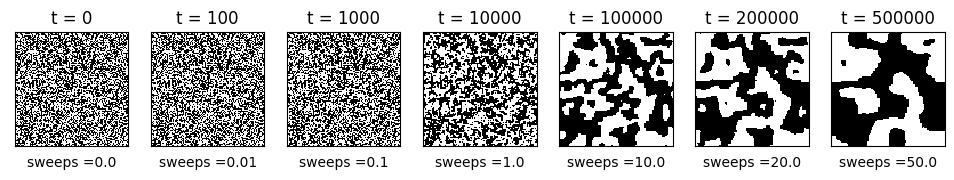

In [3]:
"""beta = 1.5, N = 100^2"""

MH_states_data1 = np.load('MH_states_100_1.5.npy', allow_pickle=True)

fig, ax = plt.subplots(1, len(MH_states_data1[1]), figsize=(12,4))

for i in range(len(MH_states_data1[1])):
   initial.plot_lattice(MH_states_data1[0][i], ax[i], "t = {}".format(MH_states_data1[1][i]))
   ax[i].set_xlabel("sweeps ={}".format(MH_states_data1[2][i]))

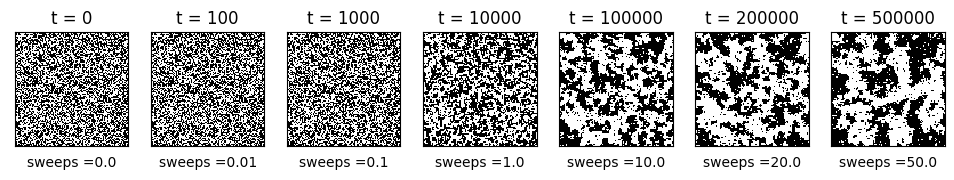

In [4]:
"""beta = 0.44, N = 100^2"""

MH_states_data2 = np.load('MH_states_100_0.44.npy', allow_pickle=True)

fig, ax = plt.subplots(1, len(MH_states_data2[1]), figsize=(12,4))

for i in range(len(MH_states_data2[1])):
   initial.plot_lattice(MH_states_data2[0][i], ax[i], "t = {}".format(MH_states_data2[1][i]))
   ax[i].set_xlabel("sweeps ={}".format(MH_states_data2[2][i]))

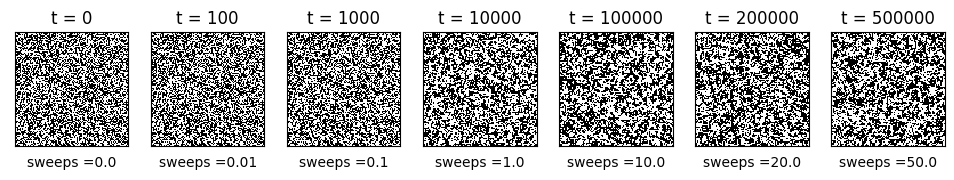

In [5]:
"""beta = 0.20, N = 100^2"""

MH_states_data3 = np.load('MH_states_100_0.20.npy', allow_pickle=True)

fig, ax = plt.subplots(1, len(MH_states_data3[1]), figsize=(12,4))

for i in range(len(MH_states_data3[1])):
   initial.plot_lattice(MH_states_data3[0][i], ax[i], "t = {}".format(MH_states_data3[1][i]))
   ax[i].set_xlabel("sweeps ={}".format(MH_states_data3[2][i]))

Where in the figures above and below, one sweep corresponds to $N = L^2$ Metropolis-Hastings flips. That is, a sweep is approximately when every spin site has been visited once.

It clearly takes a computationally significant number of sweeps in the Markov chain for the process to equilibrate. This means that when sampling from the lattice to compute physical observables, the lattice must be allowed to equilibrate with a 'burn in' period. Burn in times will be used in all following calculations. Data generated by `MH_equilibrations.py` and plotted below considers the average magnetisation for different initial states of size $N = 40^2$ and temperatures as a function of sweeps to further explore the equilibration time of this method. These plots are used as a reference for ideal burn in times. Later in the report, batching will be used as a way to average observables in a manner that means the results are more statistically independent when taking autocorrelation into account. 

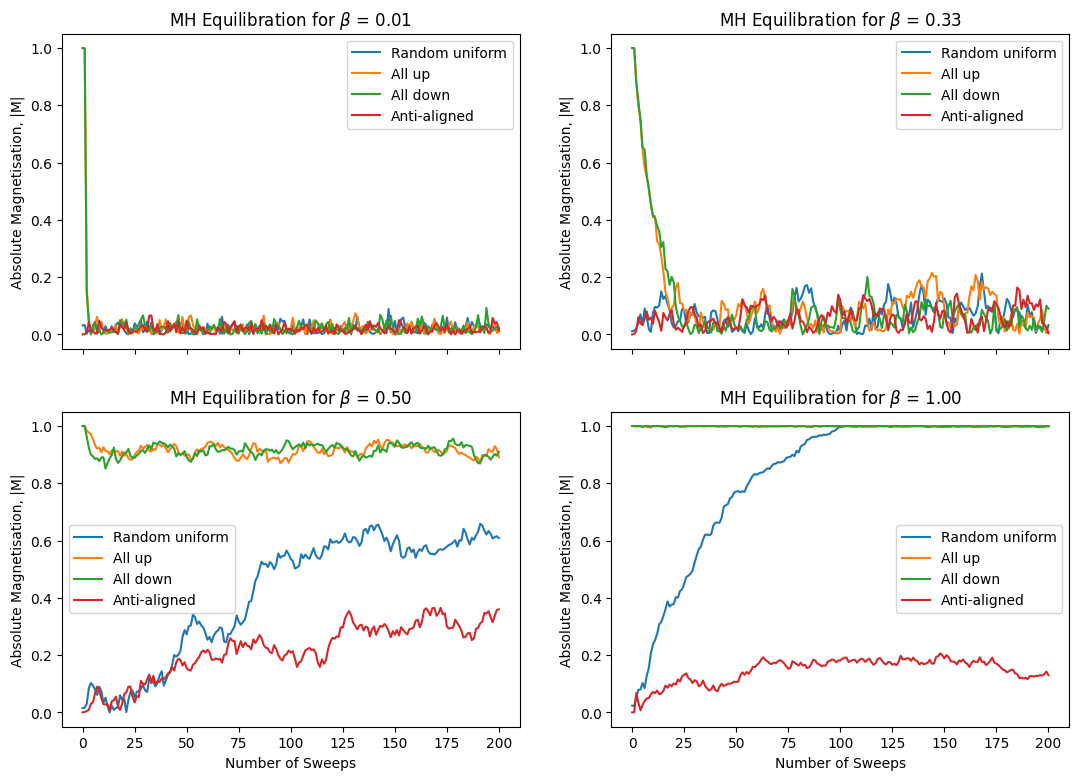

In [6]:
"""MH Equilibration plots for various temperatures
   source: MH_equilibrations.py
"""

data1 = np.load('MH_equilibration_data_0.01.npy', allow_pickle=True)
data2 = np.load('MH_equilibration_data_0.33.npy', allow_pickle=True)
data3 = np.load('MH_equilibration_data_0.50.npy', allow_pickle=True)
data4 = np.load('MH_equilibration_data_1.00.npy', allow_pickle=True)

fig, axs = plt.subplots(2,2, figsize=(13,9), sharex=True)
for i in range(4):
    axs[0,0].plot(data1[i][1], label=str(data1[i][0]))
axs[0,0].legend()
#axs[0,0].set_xlabel("Number of Sweeps")
axs[0,0].set_ylabel("Absolute Magnetisation, |M|")
axs[0,0].set_title(r"MH Equilibration for $\beta$ = 0.01")
for i in range(4):
    axs[0,1].plot(data2[i][1], label=str(data2[i][0]))
axs[0,1].legend()
#axs[0,1].set_xlabel("Number of Sweeps")
axs[0,1].set_ylabel("Absolute Magnetisation, |M|")
axs[0,1].set_title(r"MH Equilibration for $\beta$ = 0.33")
for i in range(4):
    axs[1,0].plot(data3[i][1], label=str(data3[i][0]))
axs[1,0].legend()
axs[1,0].set_xlabel("Number of Sweeps")
axs[1,0].set_ylabel("Absolute Magnetisation, |M|")
axs[1,0].set_title(r"MH Equilibration for $\beta$ = 0.50")
for i in range(4):
    axs[1,1].plot(data4[i][1], label=str(data4[i][0]))
axs[1,1].legend()
axs[1,1].set_xlabel("Number of Sweeps")
axs[1,1].set_ylabel("Absolute Magnetisation, |M|")
axs[1,1].set_title(r"MH Equilibration for $\beta$ = 1.00")
plt.show()

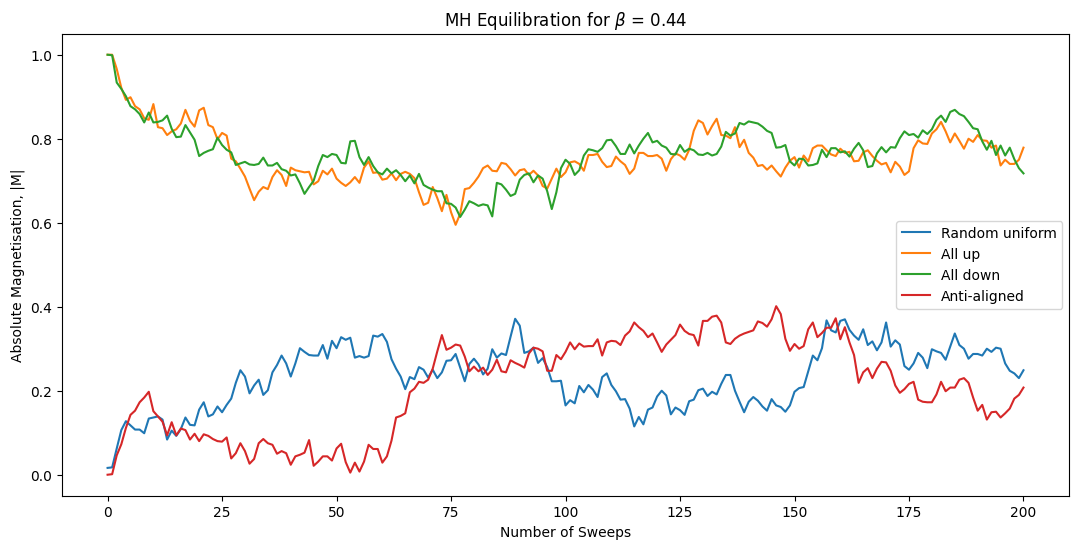

In [7]:
"""
MH Equilibration near critical temperature
source: MH_Equilibrations.py
"""

eq_data_crit = np.load('MH_equilibration_data_0.44.npy', allow_pickle=True)

fig, axs = plt.subplots(1,1, figsize=(13,6))
for i in range(4):
    axs.plot(eq_data_crit[i][1], label=str(eq_data_crit[i][0]))
axs.legend()
axs.set_xlabel("Number of Sweeps")
axs.set_ylabel("Absolute Magnetisation, |M|")
axs.set_title(r"MH Equilibration for $\beta$ = 0.44")
plt.show()

The plots show that all initial conditions have equilibrated by $\tau_{eq} \approx 30$ sweeps for the cases where the temperature is hot; that is for temparatures above above $T_c$. However, for the cases below $T_c$ the random uniform initial and anti-aligled states seem to struggle with equilibration. 

This is expected for temeperatures below $T_c$ where the equilibrium absolute magentisation per site should approach and fluctuate around 1 since the states that initially have a net magnetisation of 0 are much further away from the global minimum in phase space. This increases the chances that the states get stuck in a local annealing minimum. Given a long enough time, the states should escape this minimum but they can be stuck there for many sweeps and this is observed for the equilibration plot at $\beta = 1.00$ where the anti-aligned case is stuck for at least 200 sweeps.

### 3.3 Wolff Algorithm Implementation

Here, the Wolff algorithm described in section **2.2** is implemented and equilibrated. These functions can also be found in the `cluster.py` module and are included here for completeness.

In [30]:
"""
cluster.py
Defines wolff algorithm and other useful functions for wolff method, 
defines a different evolve_and_plot from initial for choice of both algorithms
"""
from collections import deque

def wolff_flip1(lattice, p_add):
    """
    Grows the cluster flip by flip with parameter p_add so that it is not 
    computed each step. This avoids having to store the cluster.
    """
    seed = tuple(rng.integers(0,len(lattice),2))
    
    w = len(lattice)
    
    spin = lattice[seed] # get the spin of the seed site
    lattice[seed] = -spin # flip the seed side to begin cluster
    c_size = 1 # initialize tracking of cluster size
    
    remaining_sites = deque([seed]) # track remaining unvisited cluster sites
    while remaining_sites:
        
        site = remaining_sites.pop() # remove from the remaining list
        i, j = site[0], site[1]
        
        for n in initial.get_neighbouring_sites(i,j,w):
            
            if lattice[n] == spin and rng.uniform() < p_add:
                lattice[n] = -spin
                remaining_sites.appendleft(n)
                c_size += 1 # track cluster size
    return c_size

def n_wolff_moves(lattice, p_add, n):
    """
    Carries out `n` wolff moves
    """
    total_flips = 0
    for i in range(n):
        total_flips += wolff_flip1(lattice,p_add)
    return total_flips

def evolve_and_plot_wolff(lattice, p_add, plot_times):
    """
    Evolves the lattice using MH or Wolff algorithm and plots the lattice
    at different 'time steps'.
    """
    fig, ax = plt.subplots(1, len(plot_times), figsize=(12,4))

    sweeps = 0
    flip_count = 0
    for t in range(plot_times[-1]+1):
        flip_count += wolff_flip1(lattice, p_add)
        if t in plot_times:
            sweeps = flip_count/np.size(lattice)
            initial.plot_lattice(lattice, ax[plot_times.index(t)], "t = {}".format(t))
            ax[plot_times.index(t)].set_xlabel("sweeps = {}".format(sweeps))
    plt.show()

As with the Metropolis case. The Wolff algorithm is tested for different values of $\beta$ with a lattice size of $N = 100^2$ by plotting the states at time intervals using the new `evolve_and_plot_wolff` function found above and in `evolve_and_plot.py`. The equilibration plots generated with `wolff_equilibration.py` are for lattices of size $N = 40^2$.

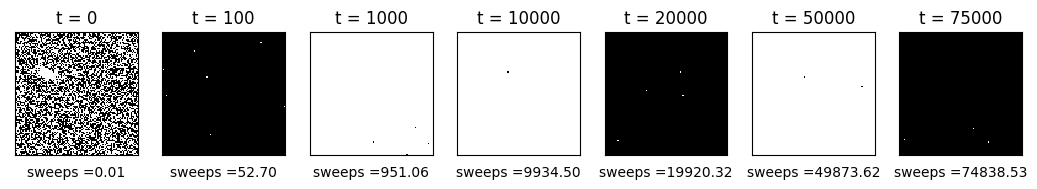

In [8]:
"""beta = 1.00, N = 100^2"""

wolff_states_data1 = np.load('wolff_states_100_1.00.npy', allow_pickle=True)

fig, ax = plt.subplots(1, len(wolff_states_data1[1]), figsize=(13,5))

for i in range(len(wolff_states_data1[1])):
   initial.plot_lattice(wolff_states_data1[0][i], ax[i], "t = {}".format(wolff_states_data1[1][i]))
   ax[i].set_xlabel("sweeps ={}".format('%.2f'%wolff_states_data1[2][i]))

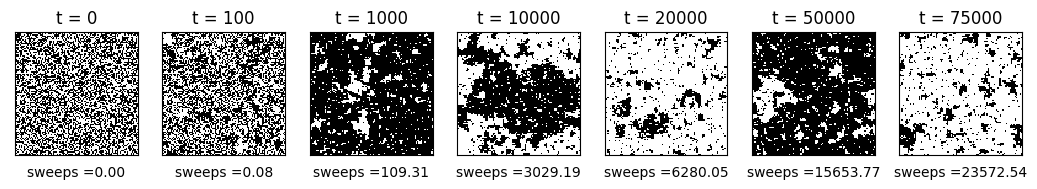

In [215]:
"""beta = 0.44, N = 100^2"""

wolff_states_data2 = np.load('wolff_states_100_0.44.npy', allow_pickle=True)

fig, ax = plt.subplots(1, len(wolff_states_data2[1]), figsize=(13,5))

for i in range(len(wolff_states_data2[1])):
   initial.plot_lattice(wolff_states_data2[0][i], ax[i], "t = {}".format(wolff_states_data2[1][i]))
   ax[i].set_xlabel("sweeps ={}".format('%.2f'%wolff_states_data2[2][i]))

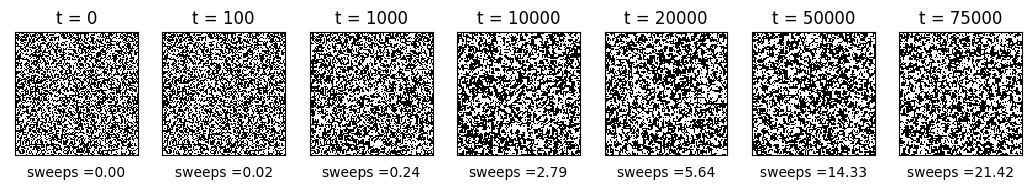

In [214]:
"""beta = 0.20, N = 100^2"""

wolff_states_data3 = np.load('wolff_states_100_0.20.npy', allow_pickle=True)

fig, ax = plt.subplots(1, len(wolff_states_data3[1]), figsize=(13,5))

for i in range(len(wolff_states_data3[1])):
   initial.plot_lattice(wolff_states_data3[0][i], ax[i], "t = {}".format(wolff_states_data3[1][i]))
   ax[i].set_xlabel("sweeps ={}".format('%.2f'%wolff_states_data3[2][i]))

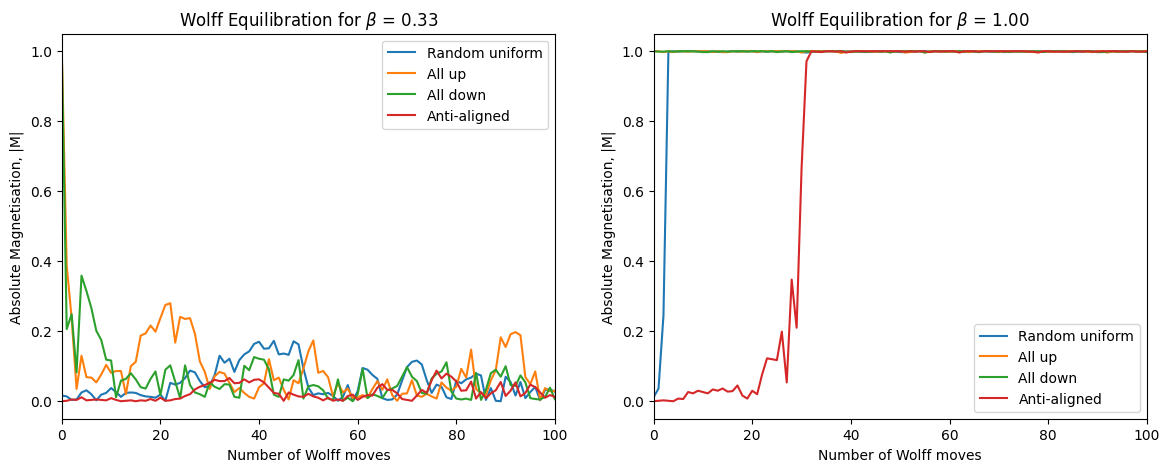

In [9]:
"""Wolff Equilibration at temperatures above and below T_c
   source: wolff_equilibrations.py
"""

eq_data1 = np.load('wolff_equilibration_data_0.33.npy', allow_pickle=True)
eq_data2 = np.load('wolff_equilibration_data_1.00.npy', allow_pickle=True)

fig, axs = plt.subplots(1,2, figsize=(14,5))
for i in range(4):
    axs[0].plot(eq_data1[i][1], label=str(eq_data1[i][0]))
axs[0].legend()
axs[0].set_xlim(0,100)
axs[0].set_xlabel("Number of Wolff moves")
axs[0].set_ylabel("Absolute Magnetisation, |M|")
axs[0].set_title(r"Wolff Equilibration for $\beta$ = 0.33")
for i in range(4):
    axs[1].plot(eq_data2[i][1], label=str(eq_data2[i][0]))
axs[1].legend()
axs[1].set_xlim(0,100)
axs[1].set_xlabel("Number of Wolff moves")
axs[1].set_ylabel("Absolute Magnetisation, |M|")
axs[1].set_title(r"Wolff Equilibration for $\beta$ = 1.00")
plt.show()

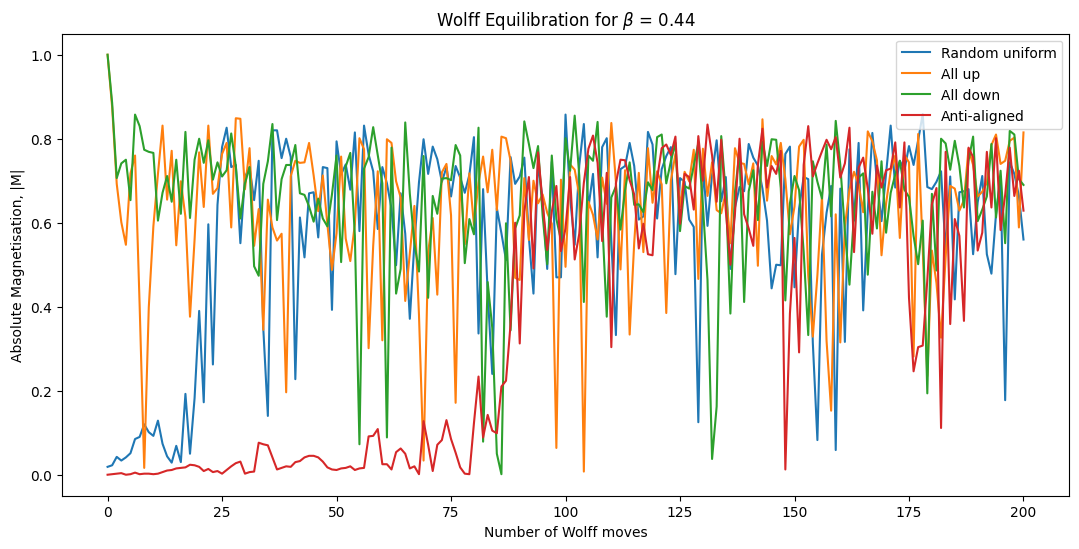

In [10]:
"""Wolff Equilibration near critical temperature
   source: wolff_equilibrations.py
"""

eq_data_crit2 = np.load('wolff_equilibration_data_0.44.npy', allow_pickle=True)

fig, axs = plt.subplots(1,1, figsize=(13,6))
for i in range(4):
    axs.plot(eq_data_crit2[i][1], label=str(eq_data_crit2[i][0]))
axs.legend()
axs.set_xlabel("Number of Wolff moves")
axs.set_ylabel("Absolute Magnetisation, |M|")
axs.set_title(r"Wolff Equilibration for $\beta$ = 0.44")
plt.show()

It can be seen from the lattice and equilibration plots that the Wolff algorithm explores the phase space much more quickly for the same number of moves. In terms of algorithm steps, the Wolff algorithm has a faster equilibrium time, however, these moves are more computationally expensive as they involve growing clusters. Cluster sizes can be on the order of the lattice size for low temperatures and so below $T_c$, runtimes become impractically large especially when compared with the MH case. At the critical temperature, the fact that many different cluster sizes are present is reflected by the magnetisation fluctuating between many values.

This leads to plot below: cluster sizes were investigated as a function of temperature generated by `cluster_sizes.py` for a lattice size of $N = 40^2$. This plot demonstrates how below the critical temperature, cluster sizes are large and as the temperature approaches zero, the cluster size quickly approaches the number of lattice sites, $N$. This plot also demonstrates that the Ising model has a second order phase transition, the two regimes are either side of the critical temperature plotted on the figure. Cluster size is intuitively related to the absolute magnetisation and so since the Wolff algorithm grows clusters of size in line with the magnetisation, multiple spin flips are much more suited to exploring phase space and decorrelating the lattice compared to the single spin flips of the MH algorithm. Indeed, this difference is most marked at the critical temperature when the lattice is highly correlated as will be further explored in section **[REFERENCE section]**.

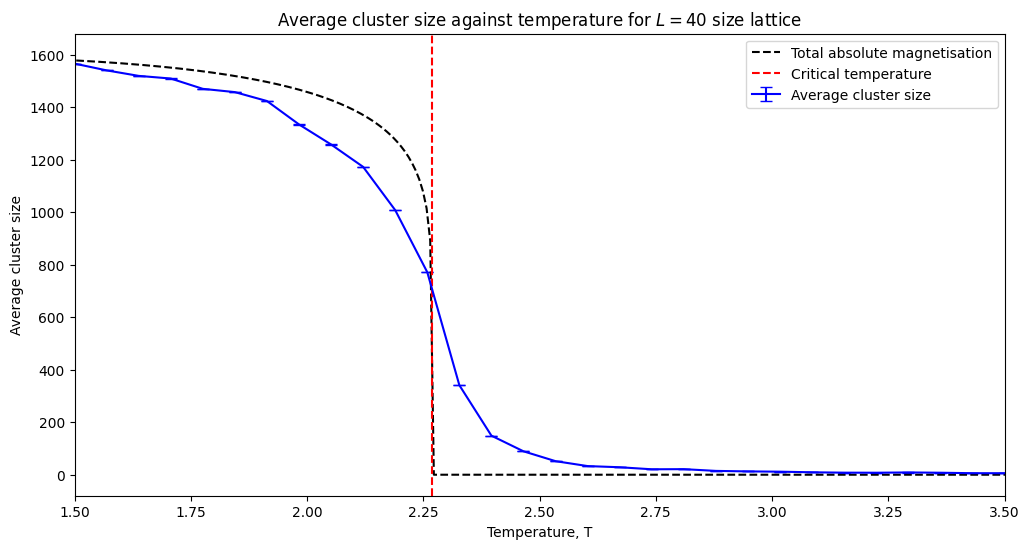

In [15]:
cluster_data = np.load('cluster_sizes_data_2.npy', allow_pickle=True)
an_data = np.load('analytical_onsager_data_temp.npy')

fig = plt.figure(figsize=(12,6))
plt.errorbar(cluster_data[0], cluster_data[1], yerr=cluster_data[2], label='Average cluster size', color='b', capsize=4)
plt.plot(an_data[0], 1600*an_data[1], label='Total absolute magnetisation', color='black', linestyle='--')
plt.axvline(x=2/(np.log(1+np.sqrt(2))), color='r', linestyle='--', label='Critical temperature')
plt.xlim(1.5,3.5)
plt.legend()
plt.title(r'Average cluster size against temperature for $L = 40$ size lattice')
plt.xlabel("Temperature, T")
plt.ylabel("Average cluster size")
plt.show()

The uncertianty in cluster sizes after a burn in of 500 wolff moves indicates that the cluster sise does not change for a given temperature to a very good approximation. This justifies the assumption that the number of sweeps in a Wolff move is number of sites divided by the cluster size at that temperature $N/C$. This will be important for the following implementation and discussion in section 3.5 when dealing with time series in terms of sweeps and steps.

### 3.4 Comparing solutions

`MH_onsager.py` and `wolff_onsager.py` have been used to compare each algorithm's solution with the analytical Onsager solution. Below are the two plots. Batching was utilised to help ensure the measurements were statistically independent.

The batching process divides $n$ measurements of a physical observable into $m$ bins, the number of bins is determined by the autocorrelation time of the data, the justification is that when the bin size $n/m$ is much larger than the autocorrelation time, the measurements will be statistically independent. The choice of bin size is $2\tau_a$. The bins are then averaged to generate a time series of statistically independent values. This time series can be averaged to give the expected value of the observable. The error $\sigma_{Q}$ for any measurable quantity $Q$ is then well defined as:
$$
\sigma^2_{Q} = \frac{1}{m-1}(\langle Q^2 \rangle - \langle Q \rangle^2)
$$


Where $\langle Q \rangle$ is an average of the averaged bins.

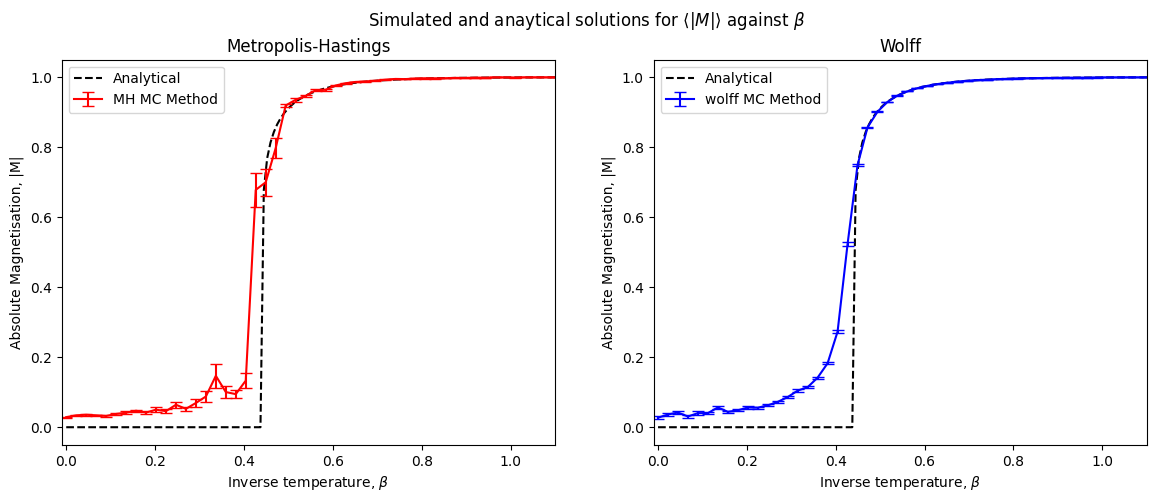

In [25]:
"""Plotting the numerical and analytical solutions for the absolute magnetisation of the lattice
source: MH_onsager.py and wolff_onsager.py
"""

MH_data = np.load('MH_onsager_data.npy')
wolff_data = np.load('wolff_onsager_data.npy')

analytical_data = np.load('analytical_onsager_data.npy')

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(analytical_data[0], analytical_data[1], label='Analytical', color='black', linestyle='--')
ax[1].plot(analytical_data[0], analytical_data[1], label='Analytical', color='black', linestyle='--')
ax[0].errorbar(MH_data[0], MH_data[1], yerr=MH_data[2], label='MH MC Method', color='red',capsize=4)
ax[1].errorbar(wolff_data[0], wolff_data[1], yerr=wolff_data[2], label='wolff MC Method', color='blue',capsize=4)
ax[0].set_title('Metropolis-Hastings')
ax[1].set_title('Wolff')
ax[0].set_xlim(-0.01,1.1)
ax[0].set_xlabel (r'Inverse temperature, $\beta$')
ax[0].set_ylabel ('Absolute Magnetisation, |M|')
ax[0].legend(loc='upper left')
ax[1].set_xlim(-0.01,1.1)
ax[1].set_xlabel (r'Inverse temperature, $\beta$')
ax[1].set_ylabel ('Absolute Magnetisation, |M|')
ax[1].legend(loc='upper left')
plt.suptitle(r'Simulated and anaytical solutions for $\langle |M| \rangle$ against $\beta$')
plt.show()

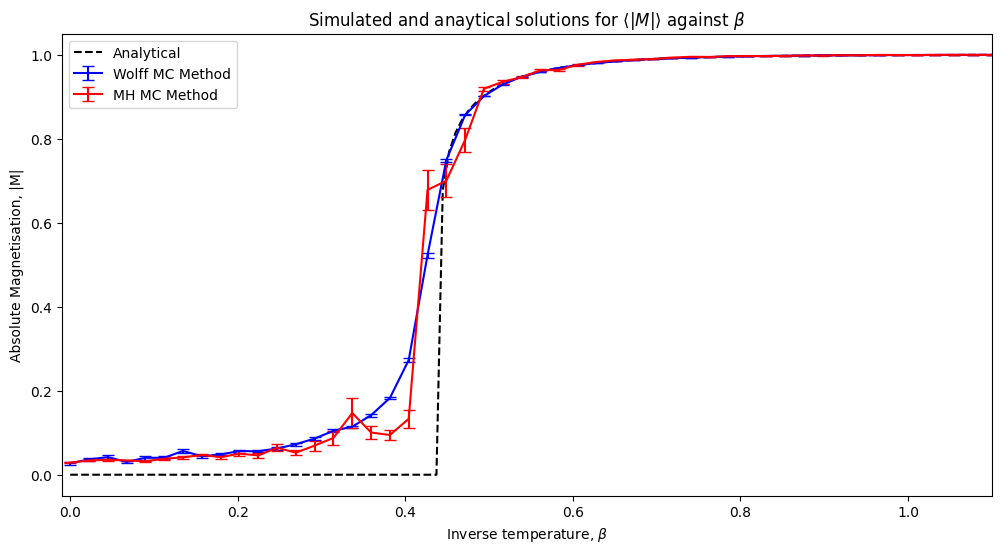

In [20]:
"""Plotting the solutions together"""

wolff_data2 = np.load('wolff_onsager_data.npy')
MH_data3 = np.load('MH_onsager_data.npy')
analytical_data = np.load('analytical_onsager_data.npy')

fig = plt.figure(figsize=(12,6))
plt.plot(analytical_data[0], analytical_data[1], label='Analytical', color='black', linestyle='--')
plt.errorbar(wolff_data2[0], wolff_data2[1], yerr=wolff_data2[2], label='Wolff MC Method', color='blue', capsize=4)
plt.errorbar(MH_data3[0], MH_data3[1], yerr=MH_data3[2], label='MH MC Method', color='red', capsize=4)
plt.xlim(-0.01,1.1)
plt.xlabel (r'Inverse temperature, $\beta$')
plt.ylabel ('Absolute Magnetisation, |M|')
plt.legend(loc='upper left')
plt.title(r'Simulated and anaytical solutions for $\langle |M| \rangle$ against $\beta$')
plt.show()

Each plot was computed for a lattice size of $L=25$ with 50 values of $\beta$. Before comparign the solutions, it is important to note that for a finite size lattice, the exact solution is not the Onsager solution in equation (6), which is the infinite size limit of the finite size problem. The finite size solutions are continuous solutions that have a smooth transition across the critical temperature and do not have discontinuous gradient. As $N$ increases, below $T_c$, the solutions get closer to 0 and the transition becomes more vertical. Exact solutions for 2x2 and 5x5 lattices can be found in this paper by **[REFERENCE]** which illustrate this trend.

In light of this discussion the numerical solutions can now be compared. The Wolff algorithm has a much more stable and smooth solution and it looks very similar to an exact solution. At the transition area, it has much smaller errors than the Metropolis solution which is much less smooth overall. This is expected and indicates that the Wolf algorithm experiences less critical slowing down than the Metropolis algorithm and performs better overall at getting solutions.

### 3.5 Autocorrelation and Critical Slowing down

This section further explores the performance of the algorithms now looking more specifically at autocorrelation functions, times and the phenomenon of critical slowing down. First, different methods of computing the autocorrelation were tested, the first method using basic libraries like numpy, the second using the statsmodels library found [here](https://www.statsmodels.org/stable/index.html). The objective was to find a time efficient way of calculating the autocorrelation so more focus could be laid on the algorithms at hand.

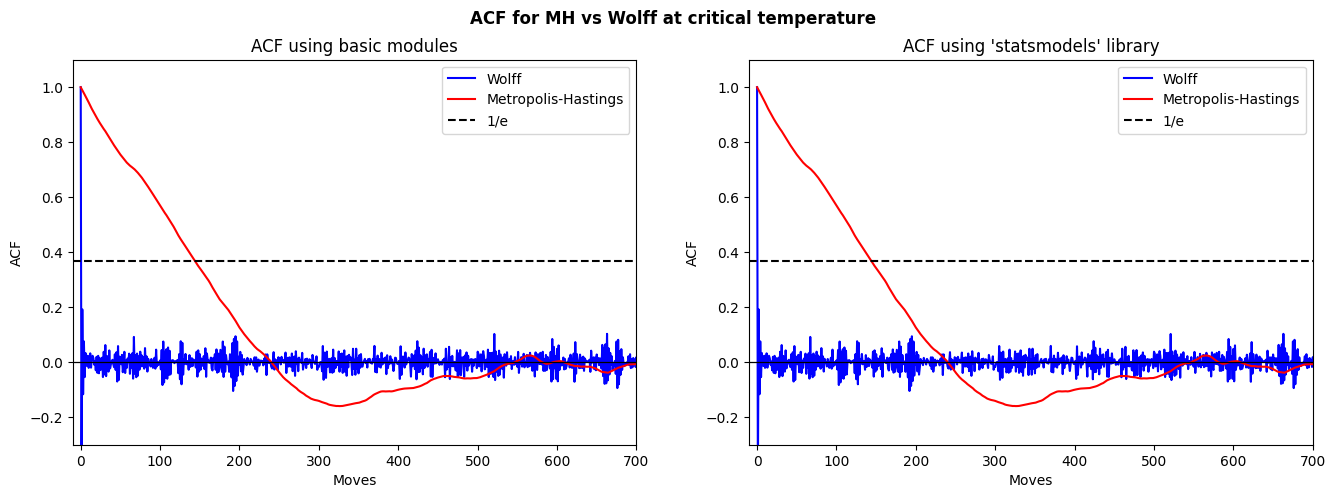

In [99]:
"""Plotting data for the autocorrelation function, using different sampling methods and ways of calculating ACF.
   Loads data from files generated by acf2.py, N = 40^2
"""

data_same = np.load('acf_basic.npy', allow_pickle=True)
data_same2 = np.load('acf_comp.npy', allow_pickle=True)

fig, ax = plt.subplots(1,2,figsize = (16,5))
fig.suptitle(r'ACF for MH vs Wolff at critical temperature', fontweight='bold')
ax[0].plot(data_same[1], label='Wolff', color='blue')
ax[0].plot(data_same[0], label='Metropolis-Hastings', color='red')
ax[1].plot(data_same2[1], label='Wolff', color='blue')
ax[1].plot(data_same2[0], label='Metropolis-Hastings', color='red')
ax[0].axhline(y=np.exp(-1), color='black', linestyle='--', label='1/e')
ax[1].axhline(y=np.exp(-1), color='black', linestyle='--', label='1/e')
ax[0].axhline(0, color='black', linewidth=0.9)
ax[1].axhline(0, color='black', linewidth=0.9)
ax[0].set_xlim(-10,700)
ax[1].set_xlim(-10,700)
ax[0].set_ylim(-0.3,1.1)
ax[1].set_ylim(-0.3,1.1)
ax[0].set_xlabel('Moves')
ax[0].set_ylabel('ACF')
ax[1].set_xlabel('Moves')
ax[1].set_ylabel('ACF')
ax[0].set_title('ACF using basic modules')
ax[1].set_title("ACF using 'statsmodels' library")
ax[0].legend()
ax[1].legend()
plt.show()

These plots clearly show the two methods generate the same series. The runtime of computing the autocorrelation function was measured for each method. The statsmodels runtime was $9.96 \pm 0.04 \times 10^{-4}$ and the basic runtime was $0.201 \pm 0.001$. The statsmodels method is 2 orders of magnitude faster than the basic method and so for the rest of this report, the statsmodels library `acf()` was used.

These plots were calculated for the autocorrelation function of the absolute magnetisation per spin for a lattice size of $L=40$ at the critical temperature. They illustrate how at the critical temperature, the metropolis experiences significant critical slowing down taking significantly more algorithm moves to decorrelate compared to the Wolff algorithm which decorrelated very quickly. However, it is important to note that a single Wolff move is more computationally expensive and in terms of physical computation time, is much slower than a single Metropolis move. The plots also demonstrate that the autocorrelation function does follow an exponential decay for at least two autocorrelation times which justifies the assumption in section 2.3. This is further explored in the logarithmic plots below.

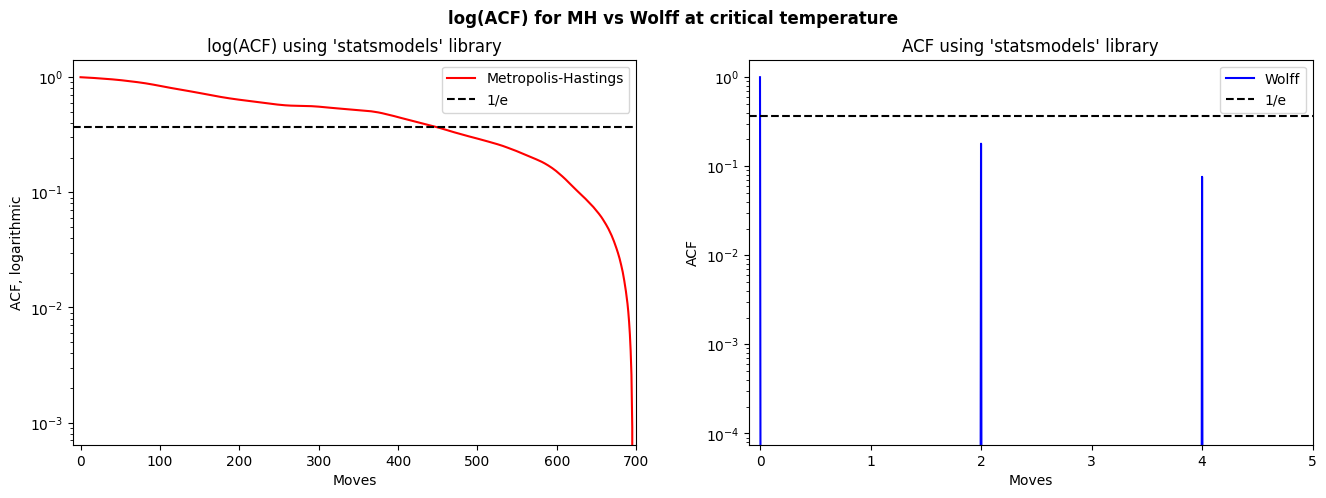

In [53]:
"""Plotting data for the autocorrelation function on a log scale
   source: acf2.py, N = 40^2
"""

data = np.load('acf_comp2.npy', allow_pickle=True)

fig, ax = plt.subplots(1,2,figsize = (16,5))
fig.suptitle(r'log(ACF) for MH vs Wolff at critical temperature', fontweight='bold')
ax[0].plot(data[0], label='Metropolis-Hastings', color='red')
ax[0].set_yscale("log")
ax[1].plot(data[1], label='Wolff', color='blue')
ax[1].set_yscale("log")
ax[0].axhline(y=np.exp(-1), color='black', linestyle='--', label='1/e')
ax[1].axhline(y=np.exp(-1), color='black', linestyle='--', label='1/e')
ax[0].set_xlim(-10,700)
ax[1].set_xlim(-0.1,5)
ax[0].set_xlabel('Moves')
ax[0].set_ylabel('ACF, logarithmic')
ax[1].set_xlabel('Moves')
ax[1].set_ylabel('ACF')
ax[0].set_title("log(ACF) using 'statsmodels' library")
ax[1].set_title("ACF using 'statsmodels' library")
ax[0].legend()
ax[1].legend()
plt.show()

These plots were generated with new data. The Metropolis autocorrelation is approximately linear for at least one autocorrelation time but faster decaying modes appear after this. The plot is not useful for the wolff algorithm which decorrelates after 1 move and quickly oscilates around zero again illustrating how quickly it moves through the state space.

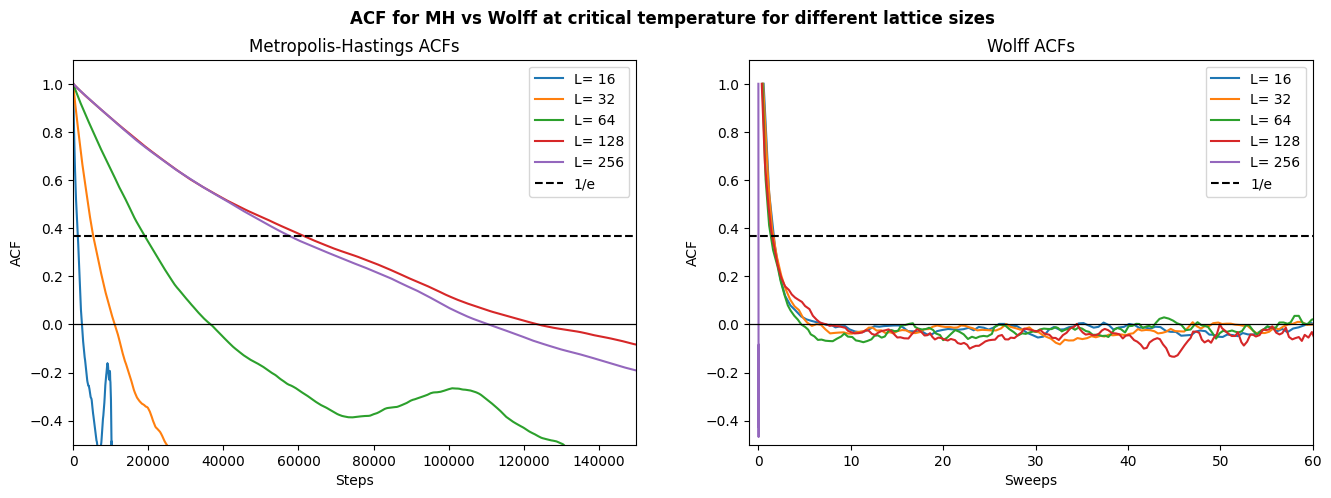

In [123]:
"""Plotting the autocorrelation function at different lattice sizes
   source: acf3.py
"""
wolff_data = [np.load('wolff_acf_16.npy'), np.load('wolff_acf_32.npy'), np.load('wolff_acf_64.npy'), 
              np.load('wolff_acf_128.npy'), np.load('wolff_acf_256.npy')]

mh_data = [np.load('MH_acf_16_2.npy'), np.load('MH_acf_32_2.npy'), np.load('MH_acf_64_2.npy'),
           np.load('MH_acf_128_2.npy'), np.load('MH_acf_256_2.npy')]

widths = [16,32,64,128,256]

fig, ax = plt.subplots(1,2,figsize = (16,5))
fig.suptitle('ACF for MH vs Wolff at critical temperature for different lattice sizes', fontweight='bold')

for i in range(5):
   ax[1].plot(wolff_data[i][0], wolff_data[i][1], label=('L= ' + str(widths[i])))
   ax[0].plot(mh_data[i][0], label=('L= ' + str(widths[i])))

ax[0].axhline(y=np.exp(-1), color='black', linestyle='--', label='1/e')
ax[1].axhline(y=np.exp(-1), color='black', linestyle='--', label='1/e')
ax[0].axhline(0, color='black', linewidth=0.9)
ax[1].axhline(0, color='black', linewidth=0.9)
ax[0].set_ylim(-0.5,1.1)
ax[1].set_ylim(-0.5,1.1)
ax[1].set_xlim(-1,60)
ax[0].set_xlim(-100,150000)
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('ACF')
ax[1].set_xlabel('Sweeps')
ax[1].set_ylabel('ACF')
ax[1].set_title('Wolff ACFs')
ax[0].set_title('Metropolis-Hastings ACFs')
ax[0].legend()
ax[1].legend()
plt.show()

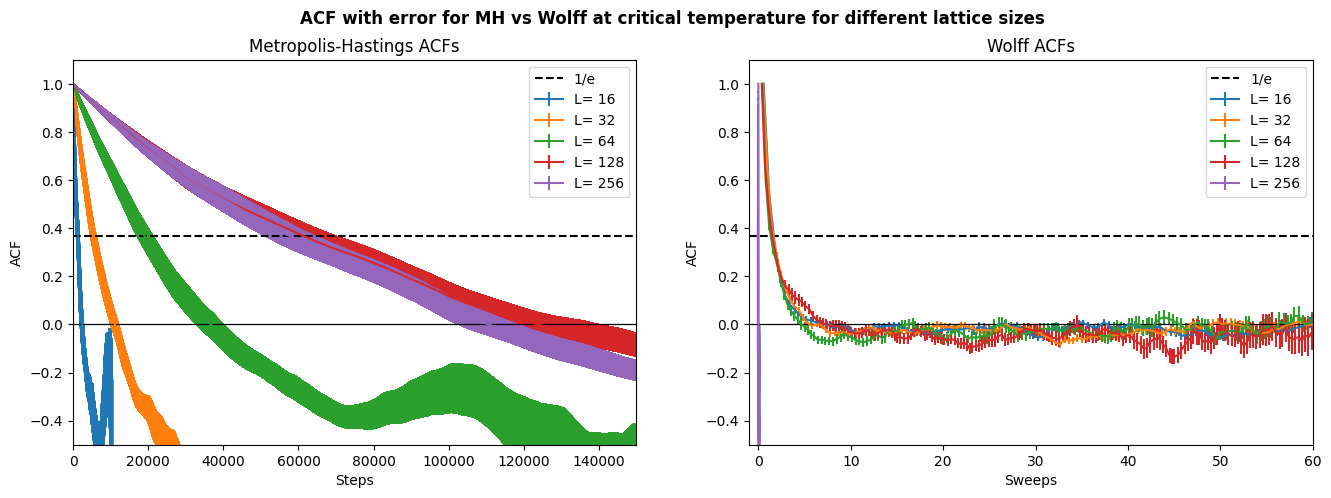

In [124]:
"""Plotting the autocorrelation function at different lattice sizes
   source: acf3.py
"""
wolff_data = [np.load('wolff_acf_16.npy'), np.load('wolff_acf_32.npy'), np.load('wolff_acf_64.npy'), 
              np.load('wolff_acf_128.npy'), np.load('wolff_acf_256.npy')]

mh_data = [np.load('MH_acf_16_2.npy'), np.load('MH_acf_32_2.npy'), np.load('MH_acf_64_2.npy'),
           np.load('MH_acf_128_2.npy'), np.load('MH_acf_256_2.npy')]

widths = [16,32,64,128,256]

fig, ax = plt.subplots(1,2,figsize = (16,5))
fig.suptitle('ACF with error for MH vs Wolff at critical temperature for different lattice sizes', fontweight='bold')

for i in range(5):
   ax[1].errorbar(x=wolff_data[i][0], y=wolff_data[i][1], yerr=wolff_data[i][2], label=('L= ' + str(widths[i])))
   ax[0].errorbar(x=range(len(mh_data[i][0])), y=mh_data[i][0], yerr=mh_data[i][1], label=('L= ' + str(widths[i])))

ax[0].axhline(y=np.exp(-1), color='black', linestyle='--', label='1/e')
ax[1].axhline(y=np.exp(-1), color='black', linestyle='--', label='1/e')
ax[0].axhline(0, color='black', linewidth=0.9)
ax[1].axhline(0, color='black', linewidth=0.9)
ax[0].set_ylim(-0.5,1.1)
ax[1].set_ylim(-0.5,1.1)
ax[1].set_xlim(-1,60)
ax[0].set_xlim(-100,150000)
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('ACF')
ax[1].set_xlabel('Sweeps')
ax[1].set_ylabel('ACF')
ax[1].set_title('Wolff ACFs')
ax[0].set_title('Metropolis-Hastings ACFs')
ax[0].legend()
ax[1].legend()
plt.show()

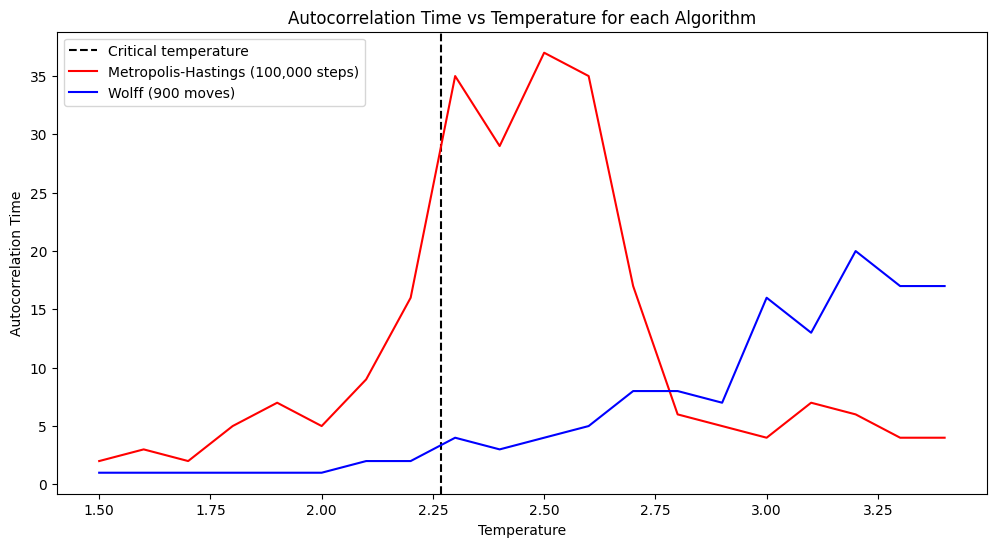

In [193]:
"""MORE DATA REQUIRED FOR HIGHER TEMPERATURES"""

wadata = np.load('wolff_autocorrelation_data.npy')
mhadata = np.load('MH_autocorrelation_data.npy')

plt.figure(figsize=(12,6))
plt.axvline(x=2/(np.log(1+np.sqrt(2))), color='black', linestyle='--', label='Critical temperature')
plt.plot(mhadata[0], mhadata[1], label='Metropolis-Hastings (100,000 steps)', color='red')
plt.plot(wadata[0], wadata[1], label='Wolff (900 moves)', color='blue')
plt.xlabel('Temperature')
plt.ylabel('Autocorrelation Time')
plt.title('Autocorrelation Time vs Temperature for each Algorithm')
plt.legend(loc='upper left')
plt.show()

[19] C.N. Yang, The spontaneous magnetization of a two-dimensional Ising model, Phys. Rev. 85 (1952) 808-816.